## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader

from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.models.deeplabv2 import DeepLabV2, deeplab_v2_style_resnet
from torchlake.semantic_segmentation.models.scale_aware import ScaleAwareLoss, ScaleAware

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/scale-aware")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
TRAIN_IMAGE_SIZE = 320
TEST_IMAGE_SIZE = 512
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

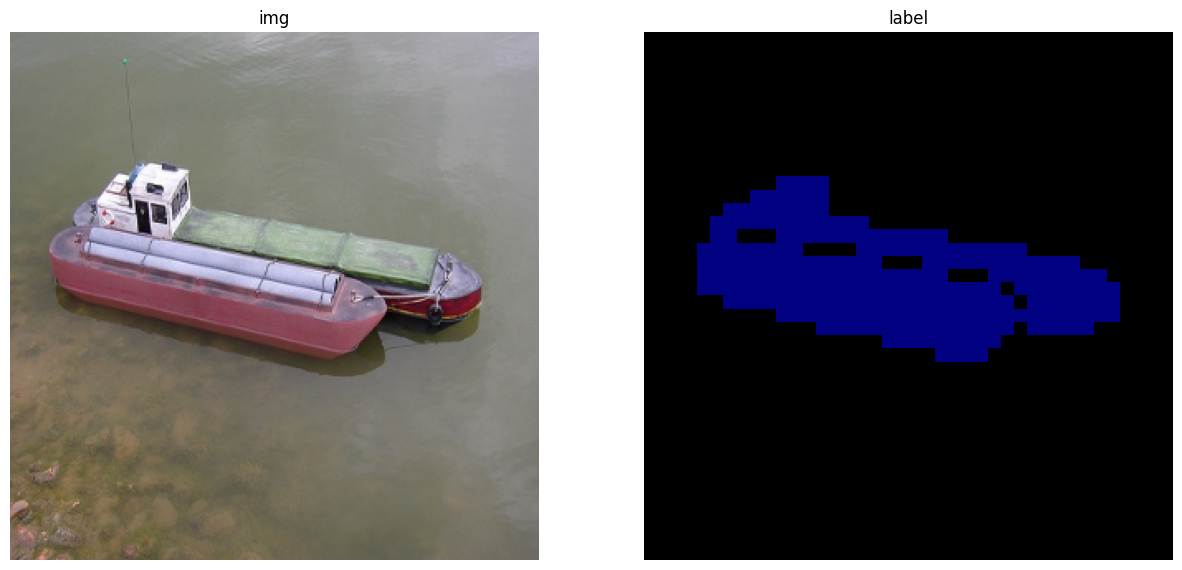

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [11]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([8, 3, 320, 320])
torch.Size([8, 40, 40])


# model

In [12]:
backbone = deeplab_v2_style_resnet("resnet101", trainable=True)
ss_model = DeepLabV2(backbone, output_size=NUM_CLASS+1, enable_shallow_aspp=True)
model = ScaleAware(ss_model, scales=(1, 0.75, 0.5)).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
ScaleAware                                              --
├─DeepLabV2: 1-1                                        --
│    └─ResNetFeatureExtractor: 2-1                      --
│    │    └─Sequential: 3-1                             42,500,160
│    │    └─ImageNetNormalization: 3-2                  --
│    └─Sequential: 2-2                                  --
│    │    └─ShallowASPP: 3-3                            1,548,372
├─ScaleAwareAttention: 1-2                              --
│    └─Sequential: 2-3                                  --
│    │    └─Conv2d: 3-4                                 290,816
│    │    └─ReLU: 3-5                                   --
│    │    └─Conv2d: 3-6                                 1,539
│    │    └─Dropout: 3-7                                --
Total params: 44,340,887
Trainable params: 44,340,887
Non-trainable params: 0

# train

In [14]:
EPOCHS = 30

In [15]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [16]:
criterion = ScaleAwareLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [18]:
scaler = torch.amp.grad_scaler.GradScaler(DEVICE)

In [19]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 364/364 [03:52<00:00,  1.56it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.3456e-01 (0.00%)


100%|██████████| 364/364 [01:54<00:00,  3.19it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.6068e-01 (-52.00%)


100%|██████████| 364/364 [01:50<00:00,  3.29it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.2028e-01 (-25.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 4
------------------------------------
total: 9.7119e-02 (-19.00%)


100%|██████████| 364/364 [01:51<00:00,  3.28it/s]


------------------------------------
Epoch 5
------------------------------------
total: 8.5869e-02 (-12.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 6
------------------------------------
total: 7.5697e-02 (-12.00%)


100%|██████████| 364/364 [01:51<00:00,  3.27it/s]


------------------------------------
Epoch 7
------------------------------------
total: 6.7536e-02 (-11.00%)


100%|██████████| 364/364 [01:50<00:00,  3.29it/s]


------------------------------------
Epoch 8
------------------------------------
total: 6.0880e-02 (-10.00%)


100%|██████████| 364/364 [01:51<00:00,  3.26it/s]


------------------------------------
Epoch 9
------------------------------------
total: 5.6793e-02 (-7.00%)


100%|██████████| 364/364 [01:51<00:00,  3.27it/s]


------------------------------------
Epoch 10
------------------------------------
total: 5.4023e-02 (-5.00%)


100%|██████████| 364/364 [01:51<00:00,  3.27it/s]


------------------------------------
Epoch 11
------------------------------------
total: 5.4038e-02 (0.00%)


100%|██████████| 364/364 [01:51<00:00,  3.28it/s]


------------------------------------
Epoch 12
------------------------------------
total: 4.9061e-02 (-9.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 13
------------------------------------
total: 5.3676e-02 (9.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 14
------------------------------------
total: 5.2398e-02 (-2.00%)


100%|██████████| 364/364 [01:50<00:00,  3.29it/s]


------------------------------------
Epoch 15
------------------------------------
total: 4.5749e-02 (-13.00%)


100%|██████████| 364/364 [01:50<00:00,  3.29it/s]


------------------------------------
Epoch 16
------------------------------------
total: 4.2100e-02 (-8.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 17
------------------------------------
total: 4.0303e-02 (-4.00%)


100%|██████████| 364/364 [02:30<00:00,  2.41it/s]


------------------------------------
Epoch 18
------------------------------------
total: 3.7619e-02 (-7.00%)


100%|██████████| 364/364 [02:43<00:00,  2.23it/s]


------------------------------------
Epoch 19
------------------------------------
total: 3.5997e-02 (-4.00%)


100%|██████████| 364/364 [02:43<00:00,  2.22it/s]


------------------------------------
Epoch 20
------------------------------------
total: 3.4398e-02 (-4.00%)


100%|██████████| 364/364 [02:43<00:00,  2.23it/s]


------------------------------------
Epoch 21
------------------------------------
total: 3.3015e-02 (-4.00%)


100%|██████████| 364/364 [02:43<00:00,  2.22it/s]


------------------------------------
Epoch 22
------------------------------------
total: 3.2597e-02 (-1.00%)


100%|██████████| 364/364 [02:43<00:00,  2.23it/s]


------------------------------------
Epoch 23
------------------------------------
total: 3.2126e-02 (-1.00%)


100%|██████████| 364/364 [02:43<00:00,  2.23it/s]


------------------------------------
Epoch 24
------------------------------------
total: 3.1623e-02 (-2.00%)


100%|██████████| 364/364 [02:00<00:00,  3.03it/s]


------------------------------------
Epoch 25
------------------------------------
total: 3.7437e-02 (18.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 26
------------------------------------
total: 4.2822e-02 (14.00%)


100%|██████████| 364/364 [01:50<00:00,  3.28it/s]


------------------------------------
Epoch 27
------------------------------------
total: 3.3098e-02 (-23.00%)


100%|██████████| 364/364 [01:51<00:00,  3.28it/s]


------------------------------------
Epoch 28
------------------------------------
total: 2.8761e-02 (-13.00%)


100%|██████████| 364/364 [01:53<00:00,  3.20it/s]


------------------------------------
Epoch 29
------------------------------------
total: 2.6811e-02 (-7.00%)


100%|██████████| 364/364 [02:02<00:00,  2.98it/s]

------------------------------------
Epoch 30
------------------------------------
total: 2.5788e-02 (-4.00%)


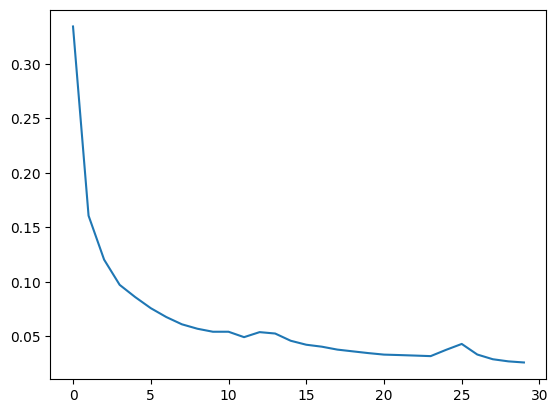

In [20]:
plt.plot(training_loss)

In [21]:
wm = WeightManager(artifacts_path.joinpath('scale-aware.deeplabv2.{backbone}.pth').as_posix())

In [22]:
model_path = wm.get_filename(backbone=backbone.network_name)
model_path

WindowsPath('../../artifacts/scale-aware/scale-aware.deeplabv2.resnet101.pth')

In [23]:
torch.save(model.state_dict(), model_path)

In [24]:
get_file_size(model_path)

'169.78MiB'

In [25]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [26]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [27]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [28]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 158/158 [01:08<00:00,  2.29it/s]


In [29]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.8  
bicycle        : 0.52 
bird           : 0.89 
boat           : 0.79 
bottle         : 0.85 
bus            : 0.91 
car            : 0.86 
cat            : 0.91 
chair          : 0.7  
cow            : 0.83 
diningtable    : 0.9  
dog            : 0.85 
horse          : 0.77 
motorbike      : 0.82 
person         : 0.84 
pottedplant    : 0.62 
sheep          : 0.85 
sofa           : 0.88 
train          : 0.89 
tvmonitor      : 0.88 
----------------------
total          : 0.82 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

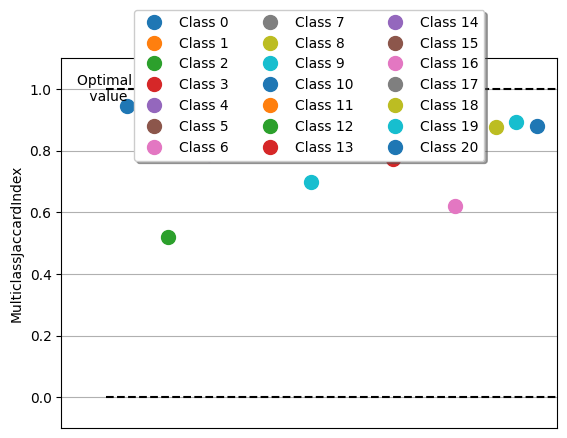

In [30]:
metric.plot()

### for image in dataset

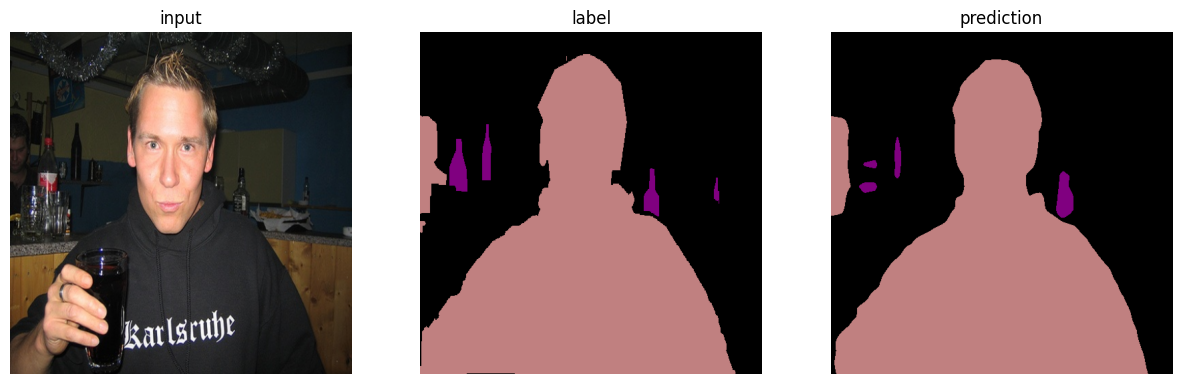

In [31]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

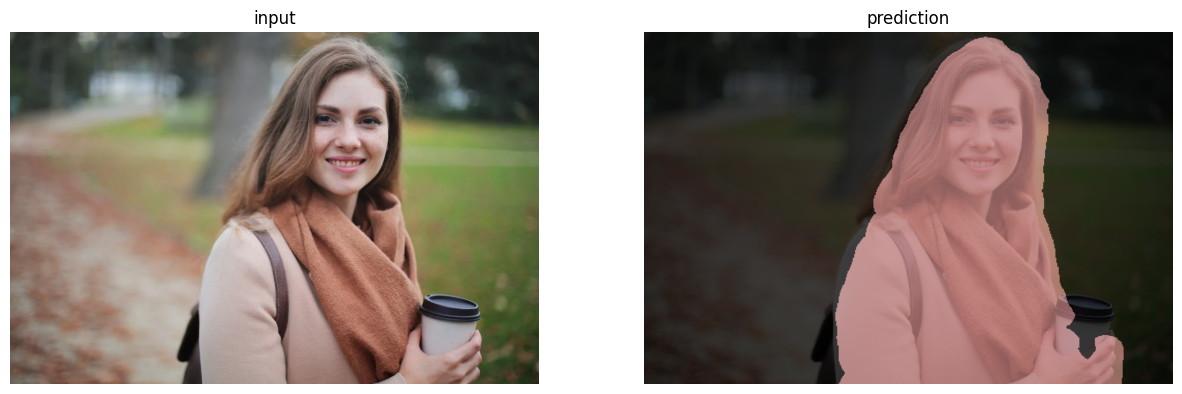

In [32]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )